# 1. Reading Data and Cleaning

In [139]:
# required libraries
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import GridSearchCV

In [ ]:
filename = "netflow_day-03"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 100000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pandas.read_csv(filename, skiprows=skip)
column_names = ['Time','Duration','SrcDevice','DstDevice','Protocol','SrcPort','DstPort','SrcPackets',
                'DstPackets','SrcBytes','DstBytes']
df.columns = column_names

In [2]:
df= pd.read_csv("random_sample")
df.shape

(100000, 11)

In [3]:
start_time = df['Time'].min()
end_time = df['Time'].max()
hour_bins = np.arange(start_time - 1, end_time + 2, step = 3600)
df['Time'] = np.searchsorted(hour_bins, df['Time'].values)
df['SrcPort'].replace(regex = True, inplace = True, to_replace = r'\D', value = r'')
df['DstPort'].replace(regex = True, inplace = True, to_replace = r'\D', value = r'')
df['SrcDevice'].replace(regex = True, inplace = True, to_replace = r'\d', value = r'')
df['DstDevice'].replace(regex = True, inplace = True, to_replace = r'\d', value = r'')
port_bins = [-1, 1023, 49151]
df['SrcPort'] = df['SrcPort'].astype(int)
df['DstPort'] = df['DstPort'].astype(int)
df['SrcPort'] = np.searchsorted(port_bins, df['SrcPort'].values)
df['DstPort'] = np.searchsorted(port_bins, df['DstPort'].values)
df['SrcDevice'] =df['SrcDevice'].astype('category')
df['DstDevice'] = df['DstDevice'].astype('category')
df['SrcPort'] =df['SrcPort'].astype('category')
df['DstPort'] = df['DstPort'].astype('category')
df['Time'] = df['Time'].astype('category')
df['Protocol'] = df['Protocol'].astype('category')
data = pd.get_dummies(df)
data.columns

Index(['Duration', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes',
       'Time_1', 'SrcDevice_ActiveDirectory', 'SrcDevice_Comp',
       'SrcDevice_EnterpriseAppServer', 'SrcDevice_IP', 'SrcDevice_VPN',
       'SrcDevice_VScanner', 'DstDevice_ActiveDirectory', 'DstDevice_Comp',
       'DstDevice_EnterpriseAppServer', 'DstDevice_IP', 'DstDevice_VPN',
       'DstDevice_VScanner', 'Protocol_1', 'Protocol_6', 'Protocol_17',
       'SrcPort_1', 'DstPort_1'],
      dtype='object')

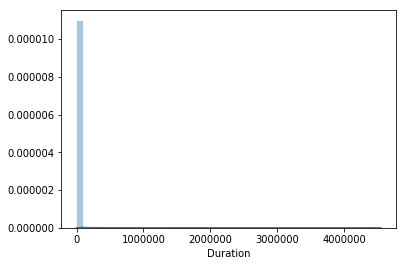

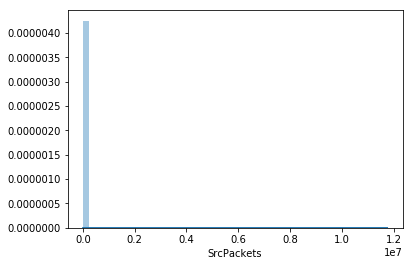

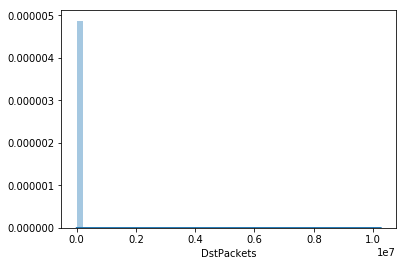

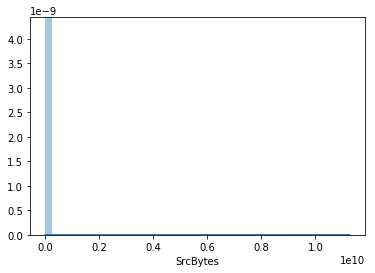

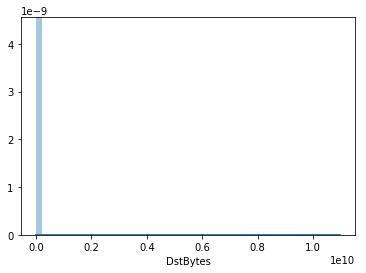

In [17]:
numero = ['Duration','SrcPackets','DstPackets','SrcBytes','DstBytes']
for i, col in enumerate(numero):
    plt.figure(i)
    sns.distplot(data[col])

In [4]:
#max scaling
data["SrcBytes"] = np.log((data["SrcBytes"])+0.001)
data["DstBytes"] = np.log((data["DstBytes"])+0.001)
data["SrcPackets"] = np.log((data["SrcPackets"])+0.001)
data["DstPackets"] = np.log((data["DstPackets"])+0.001)
data["Duration"] = np.log((data["Duration"])+0.001)

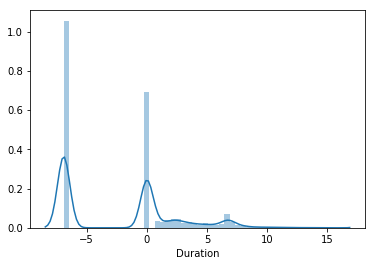

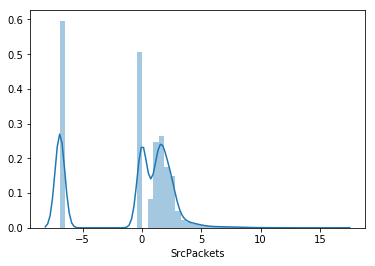

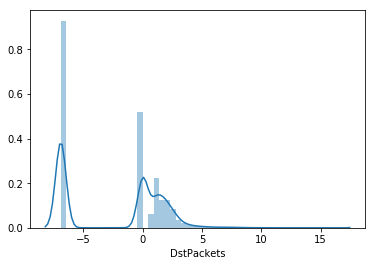

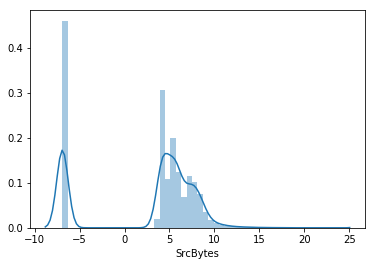

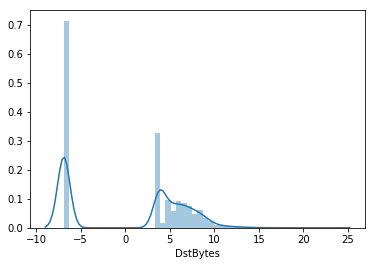

In [19]:
numero = ['Duration','SrcPackets','DstPackets','SrcBytes','DstBytes']
for i, col in enumerate(numero):
    plt.figure(i)
    sns.distplot(data[col])

In [5]:
#setting threshold for outliers
outliers_fraction = 0.05

In [6]:
data = pd.read_csv("data_for_modelling")
data.head()

,Duration,Protocol,SrcPackets,DstPackets,SrcBytes,DstBytes,Time_1,Time_2,Time_3,Time_4,...,DstDevice_EnterpriseAppServer,DstDevice_IP,DstDevice_VPN,DstDevice_VScanner,SrcPort_1,SrcPort_2,SrcPort_3,DstPort_1,DstPort_2,DstPort_3
0,-6.907755,6,-6.907755,3.737693,-6.907755,10.223395,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0.001000,6,1.946053,-6.907755,8.223896,-6.907755,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,-6.907755,17,-6.907755,0.001000,-6.907755,5.899900,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,0.001000,6,1.098946,-6.907755,5.023887,-6.907755,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1.946053,6,1.386544,-6.907755,5.480643,-6.907755,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0


# 2. Modelling

## 2.1 Model 1 - Isolation Forest Model

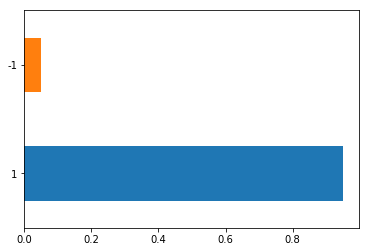

In [6]:
I = IsolationForest(behaviour='new',contamination=outliers_fraction,random_state=42)
I.fit(data)
data["Iscores"] = I.predict(data)
data.Iscores.value_counts(normalize=True).plot('barh')

## 2.2 Model 2 - One Class SVM

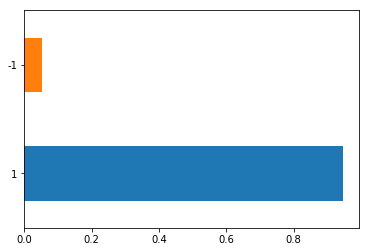

In [7]:
S = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",gamma=0.1)                    
S.fit(data)
data["Sscores"] = S.predict(data)
data.Sscores.value_counts(normalize=True).plot('barh')

## 2.3 Model 3 - Elliptical Envelope

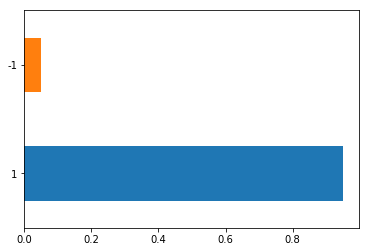

In [8]:
E = EllipticEnvelope(contamination=outliers_fraction)          
E.fit(data)
data["Escores"] = E.predict(data)
data.Escores.value_counts(normalize=True).plot('barh')

## 2.4 Model 4 - Local Outlier Factor

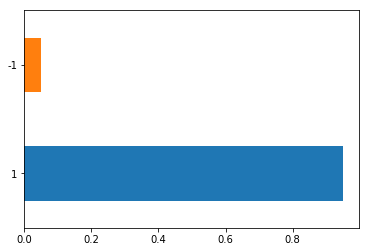

In [9]:
L = LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction)
L.fit(data)
data["Lscores"] = L.fit_predict(data)
data.Lscores.value_counts(normalize=True).plot('barh')

# 3. Model Evaluation

## 3.1 Principal Component Analysis

In [37]:
resp_variables = data.T.tail(4).T
pred_variables = data.T.head(23).T
scaler = StandardScaler()
pred_variables[pred_variables.columns] = scaler.fit_transform(pred_variables[pred_variables.columns])
pca = PCA(n_components=2)
X = pred_variables
X_r = pca.fit_transform(X)
X_c = pd.concat([pd.DataFrame(data=X_r).reset_index(drop=True), resp_variables], axis=1)
X_c.columns = ['PC1', 'PC2','Iscores','Sscores','Escroes','Lscores']

## 3.2 Visualization

### 3.2.1 Plots of of Principal Components

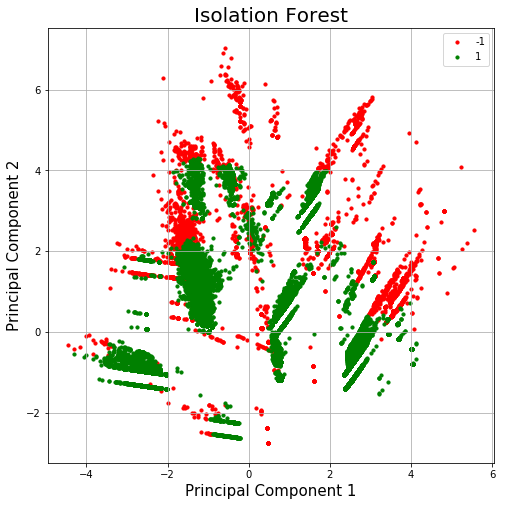

In [47]:
#Isolation Forest
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Isolation Forest', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Iscores'] == target
    ax.scatter(X_c.loc[indicesToKeep, 'PC1']
               , X_c.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

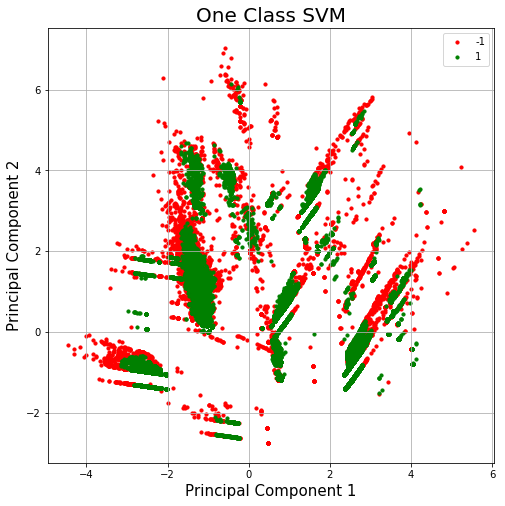

In [48]:
#One Class SVM
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('One Class SVM', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Sscores'] == target
    ax.scatter(X_c.loc[indicesToKeep, 'PC1']
               , X_c.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

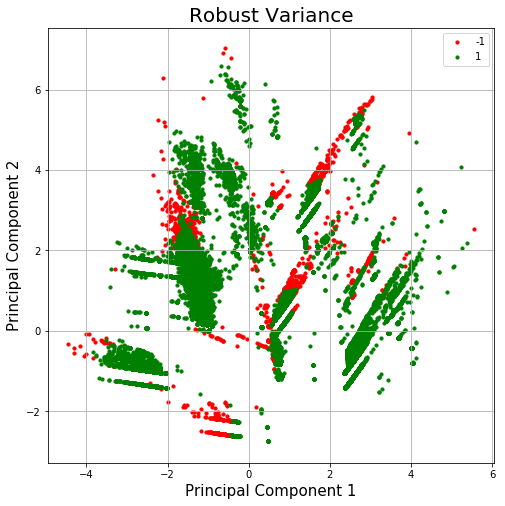

In [50]:
#Robust Covariance
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Robust Covariance', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Escroes'] == target
    ax.scatter(X_c.loc[indicesToKeep, 'PC1']
               , X_c.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

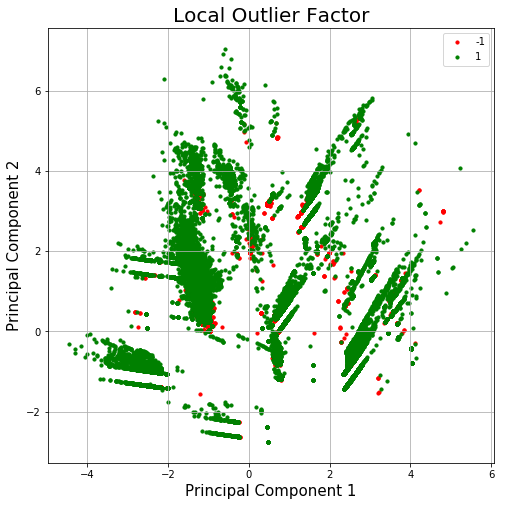

In [51]:
#Local Factor Outlier
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Local Outlier Factor', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Lscores'] == target
    ax.scatter(X_c.loc[indicesToKeep, 'PC1']
               , X_c.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

### 3.2.2 Plots between Source and Destination Packets

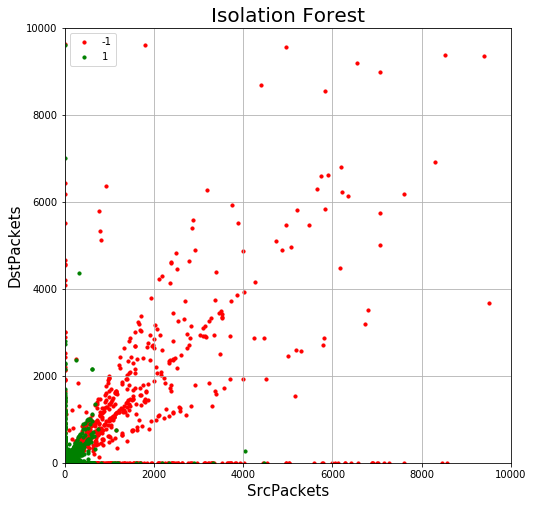

In [56]:
#Isolation Forest
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcPackets', fontsize = 15)
ax.set_ylabel('DstPackets', fontsize = 15)
ax.set_title('Isolation Forest', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Iscores'] == target
    ax.scatter(df.loc[indicesToKeep, 'SrcPackets']
               , df.loc[indicesToKeep, 'DstPackets']
               , c = color
               , s = 10)
ax.set_xlim([0, 10000])
ax.set_ylim([0, 10000])
ax.legend(targets)
ax.grid()

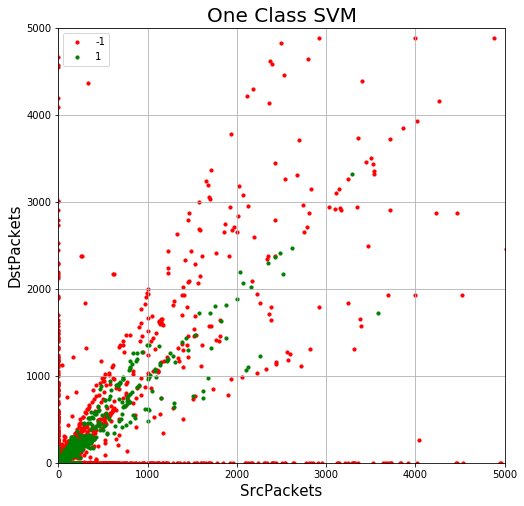

In [57]:
#One Class SVM
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcPackets', fontsize = 15)
ax.set_ylabel('DstPackets', fontsize = 15)
ax.set_title('One Class SVM', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Sscores'] == target
    ax.scatter(df.loc[indicesToKeep, 'SrcPackets']
               , df.loc[indicesToKeep, 'DstPackets']
               , c = color
               , s = 10)
ax.set_xlim([0, 5000])
ax.set_ylim([0, 5000])
ax.legend(targets)
ax.grid()

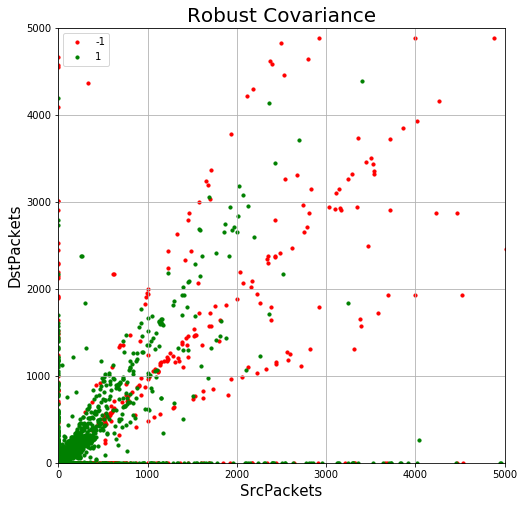

In [60]:
#Robust Covariance
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcPackets', fontsize = 15)
ax.set_ylabel('DstPackets', fontsize = 15)
ax.set_title('Robust Covariance', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Escroes'] == target
    ax.scatter(df.loc[indicesToKeep, 'SrcPackets']
               , df.loc[indicesToKeep, 'DstPackets']
               , c = color
               , s = 10)
ax.set_xlim([0, 5000])
ax.set_ylim([0, 5000])
ax.legend(targets)
ax.grid()

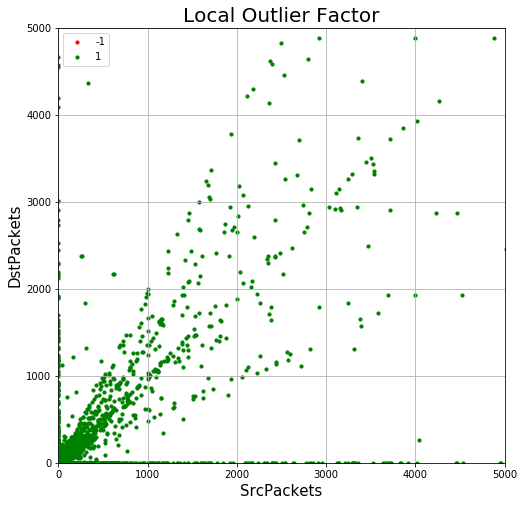

In [69]:
#Local Outlier Factor
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcPackets', fontsize = 15)
ax.set_ylabel('DstPackets', fontsize = 15)
ax.set_title('Local Outlier Factor', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Lscores'] == target
    ax.scatter(df.loc[indicesToKeep, 'SrcPackets']
               , df.loc[indicesToKeep, 'DstPackets']
               , c = color
               , s = 10)
ax.set_xlim([0, 5000])
ax.set_ylim([0, 5000])
ax.legend(targets)
ax.grid()

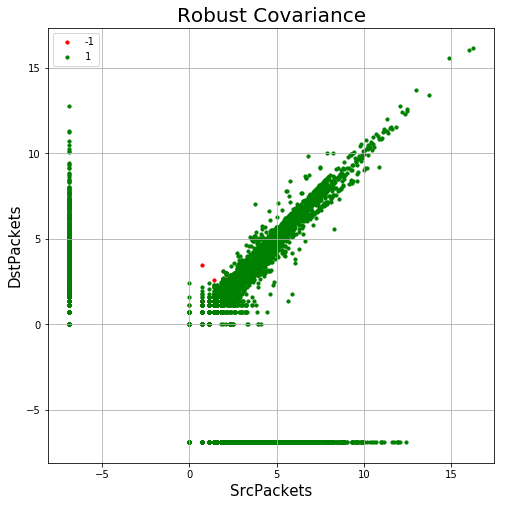

In [72]:
#Robust Covariance
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcPackets', fontsize = 15)
ax.set_ylabel('DstPackets', fontsize = 15)
ax.set_title('Robust Covariance', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Lscores'] == target
    ax.scatter(data.loc[indicesToKeep, 'SrcPackets']
               , data.loc[indicesToKeep, 'DstPackets']
               , c = color
               , s = 10)
# ax.set_xlim([0, 5000])
# ax.set_ylim([0, 5000])
ax.legend(targets)
ax.grid()

### 3.2.2 Plots between Source and Destination Bytes

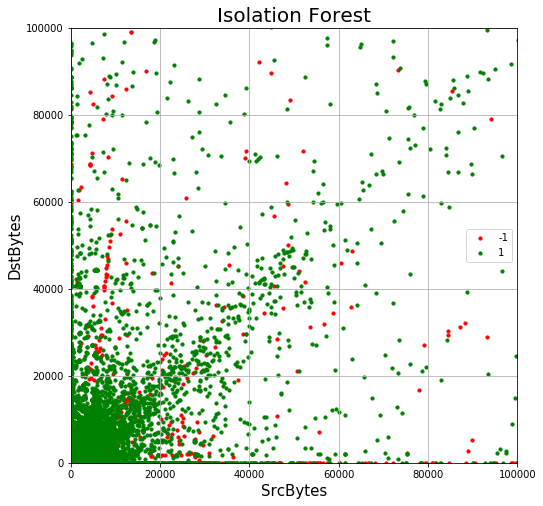

In [87]:
#Isolation Forest
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcBytes', fontsize = 15)
ax.set_ylabel('DstBytes', fontsize = 15)
ax.set_title('Isolation Forest', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Iscores'] == target
    ax.scatter(df.loc[indicesToKeep, 'SrcBytes']
               , df.loc[indicesToKeep, 'DstBytes']
               , c = color
               , s = 10)
ax.set_xlim([0, 100000])
ax.set_ylim([0, 100000])
ax.legend(targets)
ax.grid()

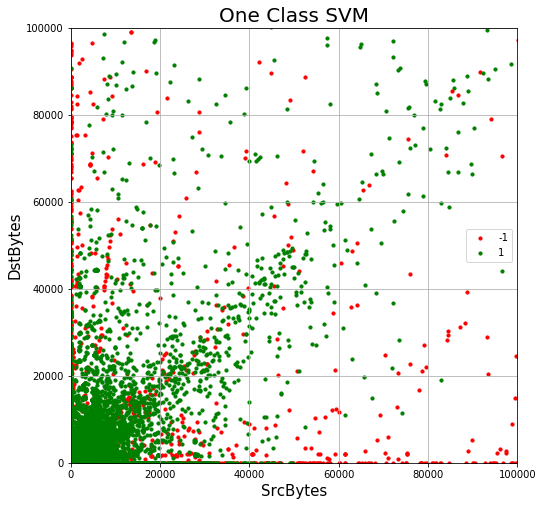

In [88]:
#One Class SVM
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcBytes', fontsize = 15)
ax.set_ylabel('DstBytes', fontsize = 15)
ax.set_title('One Class SVM', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Sscores'] == target
    ax.scatter(df.loc[indicesToKeep, 'SrcBytes']
               , df.loc[indicesToKeep, 'DstBytes']
               , c = color
               , s = 10)
ax.set_xlim([0, 100000])
ax.set_ylim([0, 100000])
ax.legend(targets)
ax.grid()

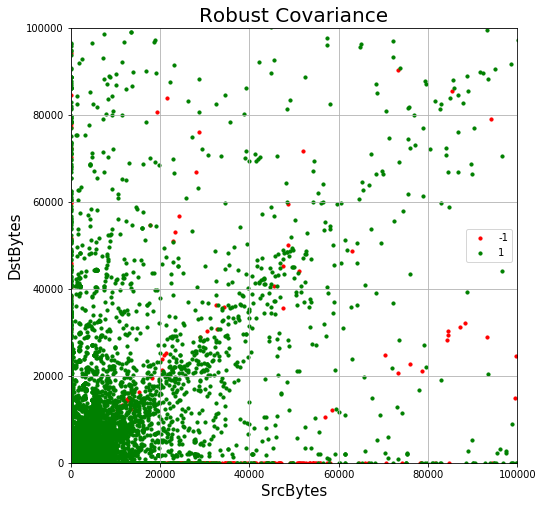

In [89]:
#Robust Covariance
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcBytes', fontsize = 15)
ax.set_ylabel('DstBytes', fontsize = 15)
ax.set_title('Robust Covariance', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Escroes'] == target
    ax.scatter(df.loc[indicesToKeep, 'SrcBytes']
               , df.loc[indicesToKeep, 'DstBytes']
               , c = color
               , s = 10)
ax.set_xlim([0, 100000])
ax.set_ylim([0, 100000])
ax.legend(targets)
ax.grid()

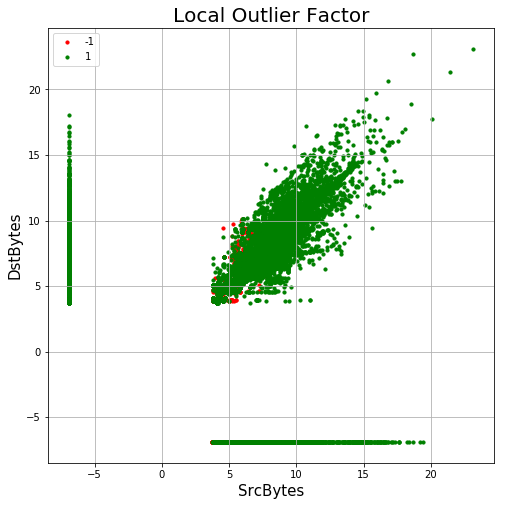

In [92]:
#Local Outlier Factor
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('SrcBytes', fontsize = 15)
ax.set_ylabel('DstBytes', fontsize = 15)
ax.set_title('Local Outlier Factor', fontsize = 20)
targets = [-1,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = X_c['Lscores'] == target
    ax.scatter(data.loc[indicesToKeep, 'SrcBytes']
               , data.loc[indicesToKeep, 'DstBytes']
               , c = color
                , s = 10)
# ax.set_xlim([0, 100000])
# ax.set_ylim([0, 100000])
ax.legend(targets)
ax.grid()

# 4. Labelling

In [47]:
data["Sum"] = data["Iscores"] + data["Sscores"] + data["Lscores"] + data["Escores"]
data["label"] = [1 if x <= -2 else 0 for x in data["Sum"]]
nonanom = data[data.label == 0]
anom = data[data.label == 1]
anom.shape
nonanom_sample = nonanom.sample(frac=0.01, replace=True, random_state=1)
labelled = anom.append(nonanom_sample)
labelled.shape
X = labelled.T.head(23).T
Y = labelled.T.tail(1).T
X.head()

,Duration,SrcPackets,DstPackets,SrcBytes,DstBytes,Time_1,SrcDevice_ActiveDirectory,SrcDevice_Comp,SrcDevice_EnterpriseAppServer,SrcDevice_IP,...,DstDevice_Comp,DstDevice_EnterpriseAppServer,DstDevice_IP,DstDevice_VPN,DstDevice_VScanner,Protocol_1,Protocol_6,Protocol_17,SrcPort_1,DstPort_1
19,6.190317,7.496653,7.244942,13.122989,11.259632,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
63,9.079206,3.951263,-6.907755,9.292197,-6.907755,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
158,-6.907755,2.890427,2.772651,7.905442,9.146548,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
356,0.001000,-6.907755,0.001000,-6.907755,5.370643,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
387,-6.907755,0.001000,0.001000,5.087603,5.308273,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


# 5. Supervised Modelling

In [50]:
#train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)


In [59]:
#function for plotting confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## 5.1 Model 1 - Logistic Regression

Confusion matrix, without normalization
[[315  16]
 [ 18 241]]


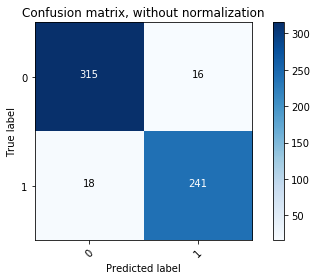

In [60]:
LR = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)
pred_y=LR.predict(X_test)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [61]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9377431906614786 0.9305019305019305 4.833836858006042 94.23728813559322


## 5.1 Model 2 - Random Forest

Confusion matrix, without normalization
[[312  19]
 [  4 255]]


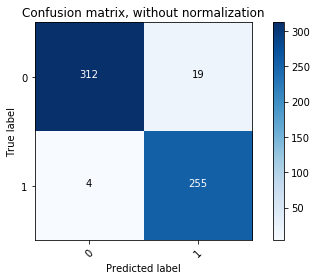

In [145]:
#Random Forest
m = RandomForestClassifier(n_estimators=50000, min_samples_leaf=50, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)
pred_y=m.predict(X_test)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [146]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9306569343065694 0.9845559845559846 5.740181268882175 96.10169491525423


## 5.3 Model 1 - Gradient Boosting Classifier

Confusion matrix, without normalization
[[319  12]
 [  8 251]]


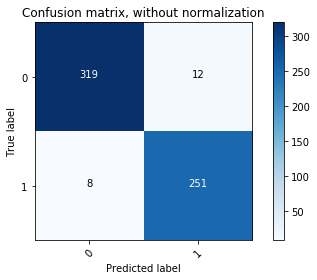

In [144]:
model = GradientBoostingClassifier(n_estimators=80, min_samples_leaf=50, max_features=0.5, learning_rate = 0.3)
model.fit(X_train, y_train)
pred_y=model.predict(X_test)
cm= confusion_matrix(y_test,pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [133]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.9545454545454546 0.972972972972973 3.625377643504532 96.77966101694915


In [91]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9644985944079598

In [140]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train.columns]
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train[predictors],y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [142]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.05513706, 0.06498652, 0.07851453, 0.10573893, 0.12314534,
         0.17169504, 0.17546024]),
  'std_fit_time': array([0.02131754, 0.00332249, 0.00624501, 0.02039903, 0.017342  ,
         0.02566173, 0.03745808]),
  'mean_score_time': array([0.00516567, 0.00249181, 0.00259151, 0.00259886, 0.01898842,
         0.00259514, 0.01090193]),
  'std_score_time': array([4.56349814e-03, 3.78085864e-05, 7.04865649e-05, 7.75356281e-05,
         1.35512239e-02, 5.26159933e-05, 1.65148002e-02]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'split0_test_score': array([0.92888764, 0.97902466, 0.98176516, 0.98253812, 0.98401377,
         0.98

In [143]:
gsearch1.best_score_

0.989442968082909